$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$
$$
u(x,0) = f(x) = e^{-x^2}, \quad x \in [-5,5]
$$

$$
u(-5,t) = g_1(t), \quad u(5,t) = g_2(t), \quad t \geq 0
$$

In [9]:
# =============
# CARGA DE LIBRERIAS

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

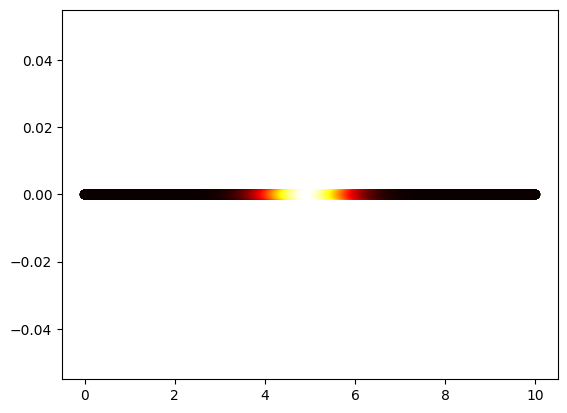

In [10]:
# PRUEBA PARA REPRESENTAR LA CONDICIÓN INICIAL EN BONITO

L = 10
N = 10000
alpha = 1  # Coeficiente de difusión térmica
thickness = 50  # Grosor de la línea

# Malla espacial
x = torch.linspace(0, L, N)

# Condición inicial: Pico de calor en el centro
u0 = torch.exp(- ((x - L/2)**2) )  # Distribución Gaussiana de temperatura

# Crear un scatter plot con colores según la temperatura
plt.figure(dpi=100)
plt.scatter(x, np.zeros_like(x), c=u0.numpy(), cmap='hot', s=thickness, edgecolors='none')

In [ ]:
# =============
# DEFINICION DEL MODELO

def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True)
    return grads

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# Parametros fisicos y de entrenamiento
alpha = 1            # Coeficiente de difusión térmica
L = 10               # dominio [0,10] en x
T_MAX = 10           # tiempo maximo
N_STEPS = 5000       # Número de iteraciones de entrenamiento
N_COLLOC = 25000     # Número de muestras para la PDE
N_BC = 25000         # Número de muestras para la condición inicial y de frontera

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definicion de la MLP para approximar Psi(x,y,t)
class HEAT(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, layers[0]),
            Sine(),
            *sum([[nn.Linear(layers[i], layers[i+1]), Sine()] 
                  for i in range(len(layers)-1)], []),
            nn.Linear(layers[-1], 1)
        )
    def forward(self, x):
        return self.net(x)

class HEAT(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, layers[0]),
            nn.ReLU(),
            *sum([[nn.Linear(layers[i], layers[i+1]), nn.ReLU()]
                    for i in range(len(layers)-1)], []),
            nn.Linear(layers[-1], 1)
        )
    def forward(self, x):
        return self.net(x)

# class HEAT(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(3, layers[0]),
#             nn.Tanh(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# Inicializar red, optimizador y scheduler
mlp = HEAT([100,100,100,100,100,100,100,100]).to(device)                            
mse = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)                    
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                milestones=[int(0.5*N_STEPS), int(0.8*N_STEPS)], gamma=0.1)

print(f"Modelo inicializado correctamente en {device}.")

Modelo inicializado correctamente en cuda.


In [12]:
# Parametros
EXTRA_EPOCHS = 5
lambda_ic    = 1000
lambda_bc    = 10
lambda_ic    = 1
lambda_bc    = 1
model_path   = 'models/heat/relu/heat'

# Carga de checkpoint previo
if os.path.exists(f"{model_path}.pth"):
    ckpt = torch.load(f"{model_path}.pth", map_location=device)
    mlp.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_epoch   = ckpt['epoch']
    print(f"Cargado checkpoint de la época {start_epoch-1:02d}.")
else:
    start_epoch   = 1
    print("No hay checkpoint previo. Empezando desde epoch 01.")

N_EPOCHS = start_epoch + EXTRA_EPOCHS

for epoch in range(start_epoch, N_EPOCHS):
    mlp.train()
    epoch_loss = 0.0

    # Bucle con tqdm
    loop = tqdm(range(1, N_STEPS+1),
                desc=f"Epoch {epoch:02d}",
                unit="step",
                delay=0.1,
                total=N_STEPS)

    for step in loop:
        # Generar muestras aleatorias en (x, t) en el dominio: x ∈ [0, L] y t ∈ [0, 100]
        x = torch.rand(N_COLLOC, 1, device=device) * L
        t = torch.rand(N_COLLOC, 1, device=device) * T_MAX
        X = torch.cat([x, t], dim=1).requires_grad_(True)

        # Evaluación de la red para obtener u(x, t)
        u = mlp(X)[:, 0].unsqueeze(1) # [N,1]

        # Cálculo de gradientes para obtener ∂u/∂t y ∂²u/∂x²
        grads = computeGrads(u, X)
        du_dt = grads[:, 1]  # ∂u/∂t
        grads2 = computeGrads(grads[:, 0], X)  # Segunda derivada en x
        d2u_dx2 = grads2[:, 0]  # ∂²u/∂x²

        # Pérdida de la ecuación del calor: ∂u/∂t = alpha * ∂²u/∂x²
        loss_pde = mse(du_dt, alpha * d2u_dx2)

        # Condición inicial: u(x, 0) = exp(-(x-5)²)
        x0 = torch.rand(N_BC, 1, device=device) * L
        t0 = torch.zeros(N_BC, 1, device=device)
        u0 = torch.exp(- ((x0 - L/2)**2) )  # Estado inicial de temperatura [N,1]
        X0 = torch.cat([x0, t0], dim=1).requires_grad_(True)
        
        u0_hat = mlp(X0)[:, 0].unsqueeze(1) # [N,1]
        loss_ic = lambda_ic*mse(u0_hat, u0)
        
        # Condiciones de frontera Dirichlet u = 0 en x = 0 y x = 10
        xb = torch.tensor([0, L], device=device).repeat(N_BC, 1).flatten()
        tb = torch.rand(N_BC * 2, device=device) * T_MAX
        Xb = torch.stack([xb, tb], axis=-1)
        ub = mlp(Xb)[:, 0].unsqueeze(1) # [N,1]
        loss_bc = lambda_bc*mse(ub, torch.zeros_like(ub))

        # Optimización
        optimizer.zero_grad()
        loss = loss_ic + loss_bc + loss_pde
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        # Mostrar metricas en la barra
        loop.set_postfix({
            "pde": f"{loss_pde.item():.2e}",
            "ic":  f"{loss_ic.item():.2e}",
            "bc":  f"{loss_bc.item():.2e}"
        })

    # Promedio de loss de la epoch
    avg_epoch_loss = epoch_loss / N_STEPS
    print(f"Epoch {epoch:02d} concluida — avg loss: {avg_epoch_loss:.3e}")

    # Guardar checkpoint de la epoca
    checkpoint_path = f"{model_path}_{epoch:02d}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss_pde': loss_pde,
        'loss_ic': loss_ic/lambda_ic,
        'loss_bc': loss_bc/lambda_bc
    }, checkpoint_path)

    # Guardar checkpoint general
    checkpoint_path = f"{model_path}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

print("Entrenamiento completado.")

No hay checkpoint previo. Empezando desde epoch 01.


Epoch 01: 100%|██████████| 5000/5000 [09:29<00:00,  8.78step/s, pde=2.82e-05, ic=2.13e-06, bc=3.82e-07]


Epoch 01 concluida — avg loss: 7.252e-04


Epoch 02: 100%|██████████| 5000/5000 [09:16<00:00,  8.99step/s, pde=1.52e-05, ic=9.06e-07, bc=2.99e-07]


Epoch 02 concluida — avg loss: 2.603e-05


Epoch 03: 100%|██████████| 5000/5000 [08:07<00:00, 10.25step/s, pde=9.78e-06, ic=3.00e-07, bc=1.72e-07]


Epoch 03 concluida — avg loss: 1.308e-05


Epoch 04: 100%|██████████| 5000/5000 [03:40<00:00, 22.69step/s, pde=5.30e-06, ic=1.50e-07, bc=1.20e-07]


Epoch 04 concluida — avg loss: 7.442e-06


Epoch 05: 100%|██████████| 5000/5000 [03:45<00:00, 22.20step/s, pde=3.70e-06, ic=1.04e-07, bc=8.37e-08]

Epoch 05 concluida — avg loss: 4.865e-06
Entrenamiento completado.


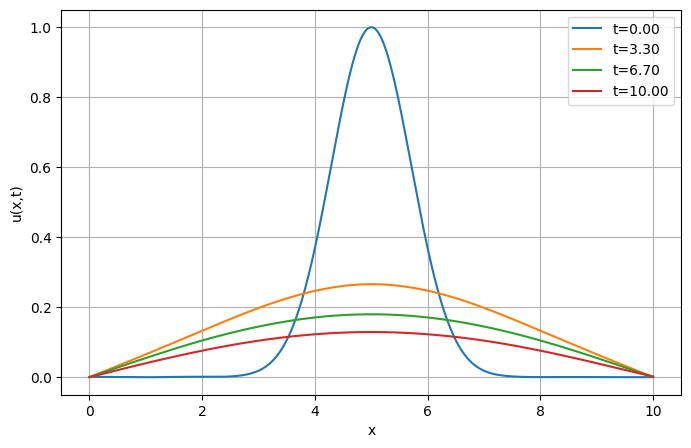

In [13]:
def run_mlp(Nx, dt, tf):
    """
    Simula la evolución de la temperatura usando la red neuronal entrenada (mlp)
    para la ecuación del calor unidimensional.
    
    Args:
    - Nx: Número de puntos en x
    - dt: Paso de tiempo
    - tf: Tiempo final

    Returns:
    - ps: Lista de vectores con las temperaturas en cada instante de tiempo
    - ts: Lista con los tiempos correspondientes
    """
    ps, ts = [], []
    t = 0

    # Discretización del dominio espacial en x
    x = np.linspace(0, L, Nx)
    X0 = torch.from_numpy(x.reshape(-1, 1)).float()  # Tensor con x, de forma (Nx, 1)
    
    mlp.eval()  # Cambiar a modo evaluación
    mlp.cpu()   # Mover a CPU
    
    while t < tf:
        with torch.no_grad():  # Desactiva gradientes para inferencia eficiente
            # Concatenar x y t para formar las entradas (x, t) de forma (Nx, 2)
            X_t = torch.cat([
                X0,  # (Nx, 1) de x
                torch.full((len(X0), 1), t)  # Tiempo t para cada punto
            ], axis=1)

            u_pred = mlp(X_t)[:, 0]  # Obtener la temperatura predicha

        ps.append(u_pred)  # Almacenar el vector de temperaturas
        ts.append(t)
        t += dt  # Avanzar en el tiempo

    return ps, ts

# Ejecutamos la simulación para obtener ps y ts
Nx = 1000    # Número de puntos en x
dt = 0.1     # Paso de tiempo
tf = 10      # Tiempo final de simulación
ps, ts = run_mlp(Nx, dt, tf)

# Definimos el eje x en base a la discretización espacial
x = np.linspace(0, L, Nx)

# Grafica estatica para varios instantes
plt.figure(figsize=(8,5))
for idx in [0, len(ts)//3, 2*len(ts)//3, -1]:
    plt.plot(x, ps[idx], label=f't={ts[idx]:.2f}')
plt.xlabel('x'); plt.ylabel('u(x,t)'); plt.legend(); plt.grid(True)
plt.show()

In [14]:
# Línea añadida para mostrar el valor en x=5 y t=10 segundos
index_zero = 500  # Índice del valor en x más cercano a 0
u_at_0_10 = ps[-1][index_zero]
if torch.is_tensor(u_at_0_10):
    u_at_0_10 = u_at_0_10.item()
print(f"El valor en x=0 y t=10 segundos es: {u_at_0_10}")

El valor en x=0 y t=10 segundos es: 0.1287234127521515


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.integrate import quad

# Parámetros del problema
L = 10.0            # Longitud del dominio: [-L/2, L/2]
Nx = 200            # Número de puntos espaciales
x = np.linspace(0, L, Nx)

# Número de términos de Fourier a usar en la serie
N_terms = 50

# Condición inicial: se escoge una función que, aunque no sea exactamente 0 en los extremos,
# tiene valores muy pequeños en x = ±L/2 (por ejemplo, u0(x)=exp(-x^2))
def u0(y):
    return np.exp(-y**2)

# Cálculo de los coeficientes de Fourier b_n
def compute_bn(n):
    # Se calcula:
    # b_n = (2/L) * ∫[−L/2,L/2] u0(y) * sin(nπ (y+L/2)/L) dy
    integrand = lambda y: u0(y - L/2) * np.sin(n * np.pi * (y) / L)
    bn, _ = quad(integrand, 0, L)
    return (2.0 / L) * bn

# Precalcular los coeficientes para n = 1, ..., N_terms
b = np.array([compute_bn(n) for n in range(1, N_terms + 1)])

# Solución de la ecuación del calor con condiciones de contorno Dirichlet:
# u(x,t) = Σ[n=1 to N_terms] b_n * sin(nπ (x+L/2)/L) * exp( - (nπ/L)^2 * t )
def heat_solution_dirichlet(x, t, N_terms=N_terms):
    u = np.zeros_like(x)
    for n in range(1, N_terms + 1):
        u += b[n-1] * np.sin(n * np.pi * (x) / L) * np.exp(- (n * np.pi / L)**2 * t)
    return u

# Parámetros temporales
tf = 10      # Tiempo final
dt = 0.1     # Paso de tiempo
ts = np.arange(0, tf + dt, dt)  # Incluye t = 0

# Calcular la solución en cada instante de tiempo
solutions = [heat_solution_dirichlet(x, t, N_terms) for t in ts]

# Configuración de la figura para la animación
fig, ax = plt.subplots(figsize=(8, 4))
line, = ax.plot(x, solutions[0], 'r-', lw=2)
ax.set_xlabel('x')
ax.set_ylabel('Temperatura')
ax.set_title('Solución de la ecuación del calor con BCs homogéneas')
ax.set_xlim(0, L)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Función de actualización para la animación
def update(frame):
    line.set_ydata(solutions[frame])
    ax.set_title(f'Tiempo: t = {ts[frame]:.2f}')
    return line,

# Crear la animación
anim = animation.FuncAnimation(fig, update, frames=len(ts), interval=200)

plt.close()  # Evita la duplicación de la figura en notebooks

# Mostrar animación
anim

from IPython.display import HTML
HTML(anim.to_html5_video())

In [16]:
def heat_solution_dirichlet(x, t, N_terms=N_terms):
    u = np.zeros_like(x, dtype=np.float64)
    for n in range(1, N_terms + 1):
        u += b[n-1] * np.sin(n * np.pi * (x + L/2) / L) * np.exp(- (n * np.pi / L)**2 * t)
    return u

u_final = heat_solution_dirichlet(np.array([0.0]), tf, N_terms)[0]
print(f"Temperatura en x=0 y t={tf} segundos: {u_final:.6f}")

a = (u_final-u_at_0_10)/u_final
print(f"Error relativo con la solución de la ecuación del calor: {a:.6f}")

Temperatura en x=0 y t=10 segundos: 0.128941
Error relativo con la solución de la ecuación del calor: 0.001686
